# Presentación 13:

En esta presentación veremos cómo ajustar y realizar pronósticos con un modelo ARIMA($p$, $d$, $q$) en Python.

Antes de comenzar veamos cómo pasar de una sucesión de números a una serie de tiempo introduciendo ruido en la sucesión. Carguemos primero algunos paquetes que necesitaremos más adelante:

In [7]:
import numpy as np # Para trabajar con vectores y matrices
from matplotlib import pyplot as plt # Para graficar
import pandas as pd # Para trabajar con bases de datos
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plt.style.use('fivethirtyeight') # Para dar un estilo distinto a los gráficos

In [8]:
# Esto es una sucesión NO una serie de tiempo:

xt = []  # Lista vacía
xt.append(0) # Valor inicial
n = 40 # Tamaño de la sucesión

for t in range(1, n, 1):
    xt.append( 1.4  + 0.6*xt[t-1] ) 

xt = np.array(xt) # Lo transformamos en vector
xt

array([0.        , 1.4       , 2.24      , 2.744     , 3.0464    ,
       3.22784   , 3.336704  , 3.4020224 , 3.44121344, 3.46472806,
       3.47883684, 3.4873021 , 3.49238126, 3.49542876, 3.49725725,
       3.49835435, 3.49901261, 3.49940757, 3.49964454, 3.49978672,
       3.49987203, 3.49992322, 3.49995393, 3.49997236, 3.49998342,
       3.49999005, 3.49999403, 3.49999642, 3.49999785, 3.49999871,
       3.49999923, 3.49999954, 3.49999972, 3.49999983, 3.4999999 ,
       3.49999994, 3.49999996, 3.49999998, 3.49999999, 3.49999999])

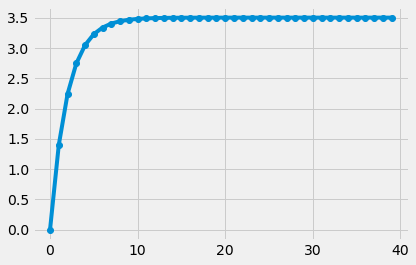

In [9]:
plt.plot(xt, marker="o")

Introduzcamos un ruido blanco normal con media $0$ y varianza $\sigma_w^2=1.3^2$ 

In [10]:
sigma_w = 1.3
np.random.seed(324) # Semilla para que obtengan lo mismo en su PC
n = 40 # Tamaño de la serie
wt = np.random.normal(0, sigma_w, n)
wt

array([ 0.02956931, -0.92990915, -0.21828726, -0.58820858,  0.90711893,
        0.05787259,  0.72550532, -1.87652107,  1.06150354, -1.44624985,
        2.18500358, -0.32286732, -0.77432918,  0.08650113, -2.47706599,
       -0.70923937,  0.60464783,  1.32897578,  1.70898244,  0.15300787,
       -1.68530777, -0.40971334,  0.76680015, -1.13342059,  0.42990819,
        1.58741991,  0.2111651 , -0.14085327, -0.95498147, -0.50364164,
        2.1013218 ,  2.2122339 ,  2.77790576,  2.42302049,  0.28696492,
        1.78508244, -0.52951783,  0.86330517,  2.62697389,  0.2543812 ])

In [11]:
# Esto SÍ es una serie de tiempo:

xt = []  # Lista vacía
xt.append(0) # Valor inicial


for t in range(1, n, 1):
    xt.append( 1.4  + 0.6*xt[t-1] + wt[t]) 

xt = np.array(xt) # Lo transformamos en vector
xt

array([0.        , 0.47009085, 1.46376725, 1.69005177, 3.32115   ,
       3.45056259, 4.19584287, 2.04098465, 3.68609433, 2.16540675,
       4.88424763, 4.00768126, 3.03027957, 3.30466887, 0.90573534,
       1.23420183, 2.74516893, 4.37607713, 5.73462872, 4.9937851 ,
       2.71096329, 2.61686464, 3.73691893, 2.50873077, 3.33514666,
       4.9885079 , 4.60426984, 4.02170863, 2.85804371, 2.61118459,
       5.06803255, 6.65305343, 8.16973782, 8.72486318, 6.92188283,
       7.33821214, 5.27340946, 5.42735085, 7.2833844 , 6.02441184])

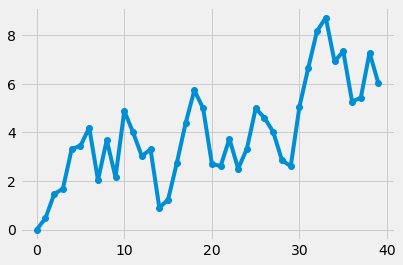

In [12]:
plt.plot(xt, marker="o")

__PREGUNTA:__ Si nos dan la serie de tiempo $\{X_t\}$ de la línea anterior, ¿cómo procedemos para separar el ruido de la parte deterministica (la sucesión)?

Para responder esto, procedamos como lo hemos hecho en el curso:

1. Realice los gráficos ACF y PACF para tratar de identificar los órdenes $p$, $d$ y $q$ del modelo ARIMA($p$, $d$, $q$).

2. Aplique la prueba de Dickey-Fuller para ver si es necesario tomar diferencias (valor de $d$). 

3. Aplique varios modelos y use un criterio de selección (AIC, BIC) para seleccionar el "mejor".

4. Verifique si existe autocorrelación en los residuales del modelo seleccionado utilizando el gráfico ACF y complementando con la prueba de Ljung-Box.

5. Verifique si hay normalidad en los residuales del modelo.

6. Si todo lo anterior se cumple entonces puede realizar pronósticos con el "mejor" modelo ajustado.

Procedamos entonces:
    
1. Gráficos ACF y PACF para tratar de identificar los órdenes $p$, $d$ y $q$ del modelo ARIMA($p$, $d$, $q$).

In [13]:
acf(xt, nlags=10)

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        ,  0.72507146,  0.4846239 ,  0.28010533,  0.17269291,
        0.22734308,  0.28258118,  0.28658224,  0.17598061,  0.02757945,
       -0.12829599])

In [14]:
pacf(xt, method='ywm', nlags=10)

array([ 1.        ,  0.72507146, -0.08666922, -0.08263003,  0.05211473,
        0.25625137,  0.05675655, -0.03405205, -0.16410095, -0.08456508,
       -0.14532481])

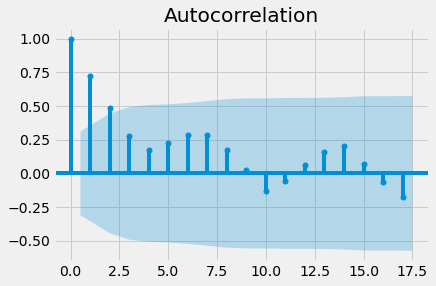

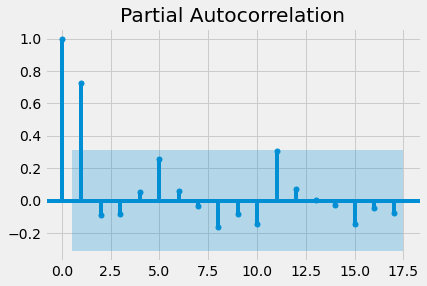

In [15]:
plot_acf(xt)
plt.show()
plot_pacf(xt, method='ywm')
plt.show()

Según los gráficos el modelo tentativo es un AR(1).

2. Aplicamos la prueba de Dickey-Fuller:

In [16]:
adfuller(xt)

(-1.042830822602314,
 0.7373241142941742,
 4,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 98.12321773355039)

In [17]:
# Para obtener información ejecutamos:
adfuller?

El p-valor es:
    

In [18]:
adfuller(xt)[1]

0.7373241142941742

Aceptamos la hipótesis nula de que existe una raíz nula, lo cual indica que debemos tomar una diferencia. Sin embargo, no lo haremos en este caso ya que sabemos que estamos simulando un AR(1).

3. Aplicamos varios modelos:

In [19]:
modelo1 = ARIMA(xt, order=(1,0,0)).fit()
modelo2 = ARIMA(xt, order=(2,0,0)).fit() 
modelo3 = ARIMA(xt, order=(1,0,1)).fit() 

In [38]:
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -68.160
Date:                Sat, 01 Oct 2022   AIC                            142.320
Time:                        13:19:21   BIC                            147.387
Sample:                             0   HQIC                           144.152
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8085      0.820      4.646      0.000       2.202       5.415
ar.L1          0.7965      0.110      7.242      0.000       0.581       1.012
sigma2         1.7246      0.525      3.286      0.001       0.696       2.753
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.88   Prob(JB):                         0.54
Heteroskedasticity (H):               1.11   Skew:                            -0.11
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -68.135
Date:                Sat, 01 Oct 2022   AIC                            144.270
Time:                        11:00:55   BIC                            151.025
Sample:                             0   HQIC                           146.712
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8161      0.801      4.761      0.000       2.245       5.387
ar.L1          0.8237      0.177      4.661      0.000       0.477       1.170
ar.L2         -0.0377      0.197     -0.191      0.848      -0.425       0.349
sigma2         1.7228      0.522      3.297      0.001       0.699       2.747
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.73   Prob(JB):                         0.54
Heteroskedasticity (H):               1.06   Skew:                            -0.12
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
modelo3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -68.142
Date:                Sat, 01 Oct 2022   AIC                            144.283
Time:                        11:00:55   BIC                            151.039
Sample:                             0   HQIC                           146.726
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8138      0.811      4.704      0.000       2.225       5.403
ar.L1          0.7817      0.160      4.882      0.000       0.468       1.095
ma.L1          0.0350      0.248      0.141      0.888      -0.450       0.520
sigma2         1.7232      0.523      3.293      0.001       0.698       2.749
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.77   Prob(JB):                         0.54
Heteroskedasticity (H):               1.07   Skew:                            -0.12
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Como era de esperarse, según los AIC y BIC, el "mejor" modelo es el __modelo1__. Los coeficientes estimados son:

In [23]:
modelo1.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,3.8085,0.820,4.646,0.000,2.202,5.415
ar.L1,0.7965,0.110,7.242,0.000,0.581,1.012
sigma2,1.7246,0.525,3.286,0.001,0.696,2.753


Vemos que los parámetros del intercepto es $\widehat{\mu}=3.8085$, de donde, $\widehat{\phi}_0=\widehat{\mu}*(1-\widehat{\phi}_1)=3.8085*(1-0.7965)=0.775$,  $\widehat{\phi}_1=0.7965$, son las estimaciones de $\phi_0=1.4$, $\phi_1=0.6$ (¿será que si aumentamos el tamaño de muestra $n$ se parecen más?). La varianza del ruido blanco es $\sigma_w^2=1.3^2=1.69$ y su estimador es igual a $\widehat{\sigma}_w^2=1.7246$

4. Observando las Pruebas de Ljung Box y Jarque-Bera del __modelo1__, los p-valores son iguales a 0.88 ($H_0$: autocorrelación nula) y 0.54 ($H_0$: Normalidad), corroboran que los residuales son no correlacionados y tienen distribución normal con un nivel de confianza del 95%.

5. Realizamos un diagnóstico de los residuales:

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


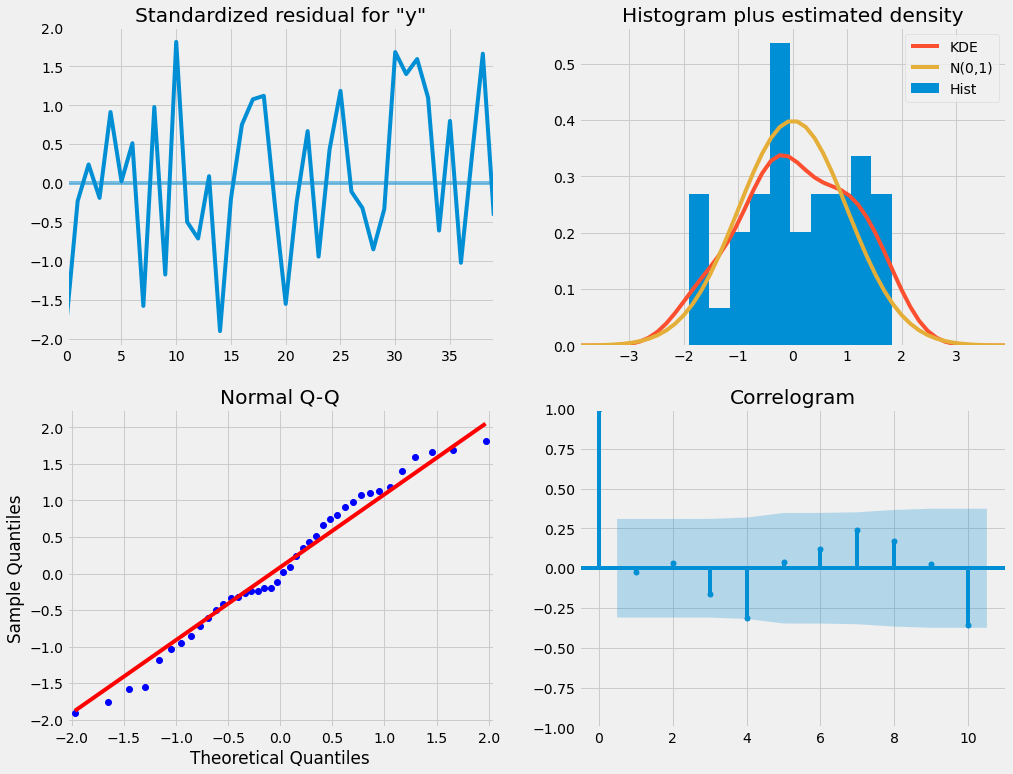

In [24]:
modelo1.plot_diagnostics(figsize=(15, 12))
plt.show()

Como era de esperarse los residuales son no correlacionados (se ve en el gráfico de la ACF con todos los valores dentro de la banda de confianza), oscilan alrededor del cero con varianza constante (primer gráfico) y se observa gráficamente que siguen una distribución normal.

6. Realizamos entonces pronósticos. Existen dos funciones o procesos: __get_prediction__ (permite hacer predicciones de toda la serie y del futuro de la misma desde un punto inicial hasta un punto final) y __get_forecast__ (solo permite realizar predicciones futuras). En escencia el  __get_forecast__ es un caso particular del __get_prediction__.

In [25]:
pred.conf_int?

Object `pred.conf_int` not found.


In [26]:
pred = modelo1.get_prediction(start=40, end=45, dynamic=False) # dynamic=False evita que las predicciones futuras
                                                               # se conviertan en datos de la muestra para predicciones 
                                                               # que van más adelante.
pred_ci = pred.conf_int(alpha=0.05) # Intervalo de confianza 
pred_ci

array([[2.99965675, 8.14743069],
       [1.92379435, 8.50502971],
       [1.25479773, 8.60190527],
       [0.8034429 , 8.59754634],
       [0.48656317, 8.55143468],
       [0.25840742, 8.49045551]])

In [27]:
pred.predicted_mean # Valores predichos a futuro.

array([5.57354372, 5.21441203, 4.9283515 , 4.70049462, 4.51899892,
       4.37443146])

In [28]:
fore = modelo1.get_forecast(6) # Obtenemos lo mismo que con el proceso anterior
fore_ci = fore.conf_int()
fore_ci

array([[2.99965675, 8.14743069],
       [1.92379435, 8.50502971],
       [1.25479773, 8.60190527],
       [0.8034429 , 8.59754634],
       [0.48656317, 8.55143468],
       [0.25840742, 8.49045551]])

In [29]:
fore.predicted_mean # Valores predichos a futuro.

array([5.57354372, 5.21441203, 4.9283515 , 4.70049462, 4.51899892,
       4.37443146])

In [30]:
xt_pred = np.concatenate((xt, fore.predicted_mean)) # Adicionamos a la serie original las predicciones.
xt_pred

array([0.        , 0.47009085, 1.46376725, 1.69005177, 3.32115   ,
       3.45056259, 4.19584287, 2.04098465, 3.68609433, 2.16540675,
       4.88424763, 4.00768126, 3.03027957, 3.30466887, 0.90573534,
       1.23420183, 2.74516893, 4.37607713, 5.73462872, 4.9937851 ,
       2.71096329, 2.61686464, 3.73691893, 2.50873077, 3.33514666,
       4.9885079 , 4.60426984, 4.02170863, 2.85804371, 2.61118459,
       5.06803255, 6.65305343, 8.16973782, 8.72486318, 6.92188283,
       7.33821214, 5.27340946, 5.42735085, 7.2833844 , 6.02441184,
       5.57354372, 5.21441203, 4.9283515 , 4.70049462, 4.51899892,
       4.37443146])

In [31]:
xt_pred[40:46]

array([5.57354372, 5.21441203, 4.9283515 , 4.70049462, 4.51899892,
       4.37443146])

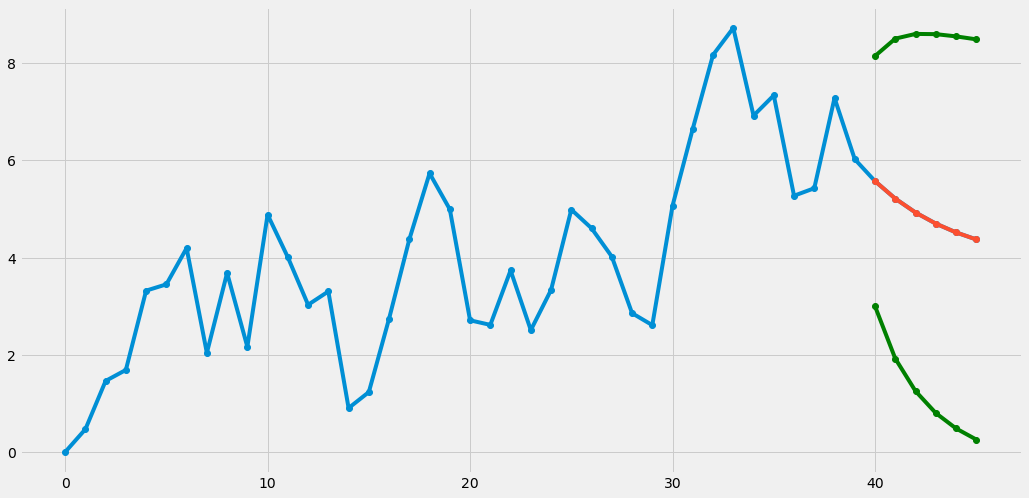

In [32]:
plt.figure(figsize=(16,8))  #  Graficamos:
plt.plot(xt_pred, marker="o")
plt.plot(range(40,46,1),xt_pred[40:46], marker="o")
plt.plot(range(40,46,1), pred_ci[:,0], marker="o", color="green")
plt.plot(range(40,46,1), pred_ci[:,1], marker="o", color="green")
plt.show()

## Incrementemos el tamaño de muestra:

Pasemos de $n=40$ a $n=200$:

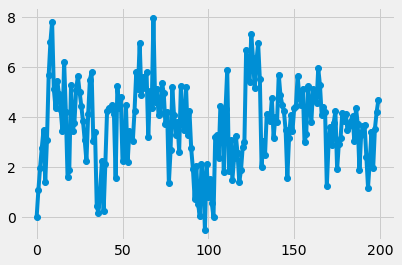

In [33]:
sigma_w = 1.3
np.random.seed(65456) # Semilla para que obtengan lo mismo en su PC
n = 200 # Tamaño de la serie
wt = np.random.normal(0, sigma_w, n)
xt = []  # Lista vacía
xt.append(0) # Valor inicial

for t in range(1, n, 1):
    xt.append( 1.4  + 0.6*xt[t-1] + wt[t]) 

xt = np.array(xt) # Lo transformamos en vector

plt.plot(xt, marker="o")

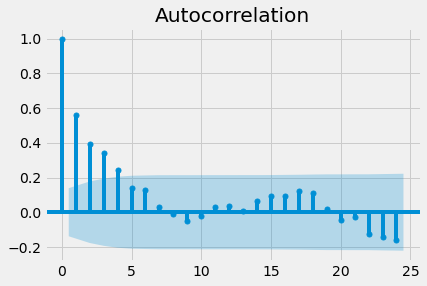

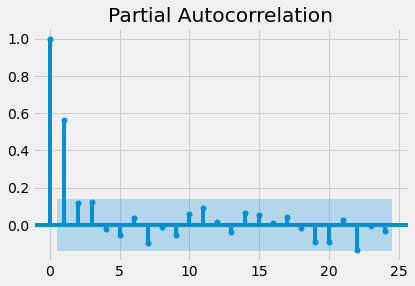

In [34]:
plot_acf(xt)
plt.show()
plot_pacf(xt, method='ywm')
plt.show()

In [35]:
adfuller(xt)

(-4.853427450443236,
 4.293377833514479e-05,
 2,
 197,
 {'1%': -3.463987334463603,
  '5%': -2.8763259091636213,
  '10%': -2.5746515171738515},
 619.0871296161191)

Con este p-valor=4.293377833514544e-05 rechazamos ahora la hipótesis nula con un nivel de confianza del 95% y nos quedamos con la alternativa: $H_a$: No hay raíces unitarias. __NOTE QUE:__ Con un tamaño de muestra mayor, el proceso simulado AR(1), con los parámetros seleccionados para que fuera estacionario, efectivamente resultó serlo. En general, en series de tiempo se requiere tener una cantidad suficiente de información para obtener inferencias correctas.

In [36]:
modelo1b = ARIMA(xt, order=(1,0,0)).fit()
modelo1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -338.656
Date:                Sat, 01 Oct 2022   AIC                            683.312
Time:                        11:00:56   BIC                            693.207
Sample:                             0   HQIC                           687.316
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6591      0.213     17.178      0.000       3.242       4.077
ar.L1          0.5762      0.060      9.548      0.000       0.458       0.695
sigma2         1.7275      0.171     10.098      0.000       1.392       2.063
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.25   Prob(JB):                         0.85
Heteroskedasticity (H):               0.43   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__NOTE QUE:__ Con aumentar el tamaño de muestra de $n=40$ a $n=200$, las estimaciones del intercepto es $\widehat{\mu}=3.6591$, de donde, $\widehat{\phi}_0=\widehat{\mu}*(1-\widehat{\phi}_1)=3.6591*(1-0.5762)=1.551$,  $\widehat{\phi}_1=0.5762$, son las estimaciones de $\phi_0=1.4$, $\phi_1=0.6$. La varianza del ruido blanco es $\sigma_w^2=1.3^2=1.69$ y su estimador es igual a $\widehat{\sigma}_w^2=1.7275$. Con una serie mayor, mayor es la información y por tanto, la estimación de los parámetros reales mejora.

# Trabajemos ahora con una serie de tiempo real:

Analicemos en Python los datos relacionados con la Tasa Representativa del Mercado (TRM).

In [37]:
from datetime import datetime # Módulo para dar formato a las fechas
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y') # Función auxiliar para dar formato a fechas

trm = pd.read_csv("../../DATOS/trm_historico.csv", parse_dates=['VIGENCIADESDE', 'VIGENCIAHASTA'], date_parser=dateparse)

FileNotFoundError: [Errno 2] No such file or directory: '../../DATOS/trm_historico.csv'

In [ ]:
trm.head()

In [ ]:
trm.tail()

In [ ]:
trm.sort_values(by="VIGENCIADESDE", inplace=True) # Ordenar por VIGENCIADESDE

In [ ]:
trm.dtypes

Podemos extraer días, meses, años, etc. de las fechas:

In [ ]:
trm["dia"] = pd.DatetimeIndex(trm["VIGENCIADESDE"]).day
trm["dia_sem"] = pd.DatetimeIndex(trm["VIGENCIADESDE"]).weekday # 0 es lunes, 1 es martes, ...,  domingo es 6
# Podemos cambiarlo con:
dia_aux1 = trm.dia_sem.unique() # Solo hay valores de 0 a 5
dia_aux2 = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"] # Solo hay días de lunes a sábado

trm.dia_sem.replace(to_replace=dia_aux1, value=dia_aux2, inplace=True)
trm["mes"] = pd.DatetimeIndex(trm["VIGENCIADESDE"]).month
trm["year"] = pd.DatetimeIndex(trm["VIGENCIADESDE"]).year

In [ ]:
trm.set_index("VIGENCIADESDE", inplace=True)

In [ ]:
trm_aux = trm[["VALOR"]].squeeze("columns")
trm_aux

In [ ]:
trm_aux.plot(figsize=(15, 6))
plt.show()

In [ ]:
acf(trm_aux)

In [ ]:
plot_acf(trm_aux)
plt.show()

In [ ]:
pacf(trm_aux, method="ywm")

In [ ]:
plot_pacf(trm_aux, method="ywm")
plt.show()

In [ ]:
adfuller(trm_aux)

Como el p-valor=0.9343293479786797 > 0.05=$\alpha$ entonces nos quedamos con la hipótesis nula $H_0:$ Existe una raíz unitaria. Esto implica que debemos tomar una diferencia:

In [ ]:
trm_aux_dif = trm_aux.diff()

In [ ]:
trm_aux_dif.dropna(inplace=True)

In [ ]:
adfuller(trm_aux_dif)

Como el p-valor=2.905813432233147e-27 < 0.05=$\alpha$ entonces nos quedamos con la hipótesis alternativa $H_a:$ No existe una raíz unitaria. Esto implica que no debemos tomar una segunda diferencia y el parámetro d=1 en el modelo ARIMA(p, d, q). 

In [ ]:
trm_aux_dif.plot(figsize=(15, 6))
plt.show()

In [ ]:
acf(trm_aux_dif)

In [ ]:
plot_acf(trm_aux_dif)
plt.show()

In [ ]:
pacf(trm_aux_dif, method="ywm")

In [ ]:
plot_pacf(trm_aux_dif, method="ywm")
plt.show()

Proponemos varios modelos:

In [ ]:
modelo_trm1 = ARIMA(trm_aux, order=(1,1,0)).fit()
modelo_trm2 = ARIMA(trm_aux, order=(0,1,1)).fit()
modelo_trm3 = ARIMA(trm_aux, order=(1,1,1)).fit()

In [ ]:
modelo_trm1.summary()

In [ ]:
modelo_trm2.summary()

In [ ]:
modelo_trm3.summary()

Aparentemente, el __modelo_trm1__ es el "mejor" entre los modelos ajustados, ya que tiene el menor AIC y BIC. A pesar de esto, el test de Jarque-Bera muestra que no hay normalidad en los residuales, a pesar de que el test de Ljung-Box sí evidencia no autocorrelación. La no-normalidad se confirma con el diagnóstico del modelo:

In [ ]:
modelo_trm1.plot_diagnostics(figsize=(15, 12))
plt.show()

## Filtremos los datos de TRM solo al año 2021:

In [ ]:
trm_2021 = trm.query("year==2021")

In [ ]:
trm_2021_aux = trm_2021[["VALOR"]]
#trm_2021_aux = trm_2021[["VALOR"]].squeeze("columns")
#trm_2021_aux.index = trm_2021_aux.index.to_period(freq='D')

In [ ]:
trm_2021_aux

In [ ]:
trm_2021_aux.plot(figsize=(15, 6))
plt.show()

In [ ]:
adfuller(trm_2021_aux)

In [ ]:
adfuller(trm_2021_aux.diff().dropna())

In [ ]:
plot_acf(trm_2021_aux.diff().dropna())
plt.show()
plot_pacf(trm_2021_aux.diff().dropna(), method='ywm')
plt.show()

Redefinimos los indices para ajustar el modelo ARIMA:

In [ ]:
trm_2021_aux.reset_index(inplace=True)
trm_2021_aux

In [ ]:
modelo_trm_2021 = ARIMA(trm_2021_aux["VALOR"], order=(1,1,0)).fit()
modelo_trm_2021.summary()

In [ ]:
modelo_trm_2021.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
trm_2021_aux.reset_index(inplace=True)

In [ ]:
fore = modelo_trm_2021.get_forecast(8)
fore_ci = fore.conf_int()
fore_ci

In [ ]:
fore.predicted_mean

In [ ]:
trm_2021_pred = np.concatenate((trm_2021_aux["VALOR"], fore.predicted_mean)) # Adicionamos a la serie original las predicciones.
trm_2021_pred[238:246]

In [ ]:
plt.figure(figsize=(16,8))  #  Graficamos:
plt.plot(trm_2021_pred, marker="o")
plt.plot(range(238, 246,1),trm_2021_pred[238:246], marker="o")
plt.plot(range(238, 246,1), fore_ci.iloc[:,0], marker="o", color="green") # Debemos usar .iloc porque fore_ci es un data frame
plt.plot(range(238, 246,1), fore_ci.iloc[:,1], marker="o", color="green") # Debemos usar .iloc porque fore_ci es un data frame
plt.show()